In [1]:
#logistic regression classifier to recognize cats

#modules
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
from PIL import Image
from scipy import ndimage

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
'''
dataset contains m_train images labeled as cat(y=1) and non-cat(y=0)
a test set of m_test images labeled as cat or non-cat
each image has shape(num_px,num_px,3)
'''
#loading dataset (data.h5)


def load_dataset():
    # Load training dataset
    with h5py.File("datasets/train_catvnoncat.h5", "r") as train_dataset:
        train_set_x_orig = np.array(train_dataset["train_set_x"][:])  # images
        train_set_y = np.array(train_dataset["train_set_y"][:])       # labels

    # Load test dataset
    with h5py.File("datasets/test_catvnoncat.h5", "r") as test_dataset:
        test_set_x_orig = np.array(test_dataset["test_set_x"][:])     # images
        test_set_y = np.array(test_dataset["test_set_y"][:])          # labels
        classes = np.array(test_dataset["list_classes"][:])           # [b'non-cat', b'cat']

    # Reshape labels to match (1, m)
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))

    return train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes

# Load the datasets
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

# Print basic information for verification
print(f"Training set shape: {train_set_x_orig.shape}, Labels: {train_set_y.shape}")
print(f"Test set shape: {test_set_x_orig.shape}, Labels: {test_set_y.shape}")
print(f"Class labels: {classes}")



Training set shape: (209, 64, 64, 3), Labels: (1, 209)
Test set shape: (50, 64, 64, 3), Labels: (1, 50)
Class labels: [b'non-cat' b'cat']


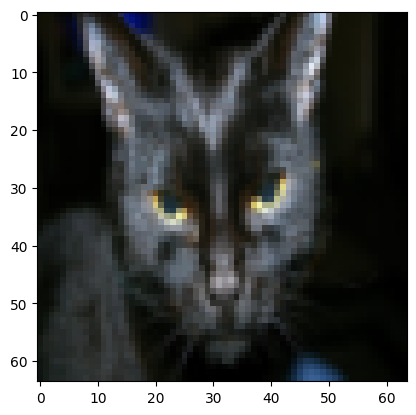

In [3]:
#example image
index = 25
plt.imshow(train_set_x_orig[index])


In [4]:
#finding number of training examples
m_train = train_set_x_orig.shape[0]
#finding number of test examples
m_test = test_set_x_orig.shape[0]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))


Number of training examples: m_train = 209
Number of testing examples: m_test = 50


In [5]:
#reshaping -  flattening out into single vectors
# X_flatten = X.reshape(X.shape[0], -1).T
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
'''
flattening is done to convert the 2D image into 1D vector 
to change how data is viewed
generally we use (features,examples) rather than (examples,features) in machine learning
'''

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

#(12288, 209) means that there are 12288 pixels and there are 209 images

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


In [6]:
#standardization

train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

'''
common steps for preprocessing are - 
1. figure out dimensions and shapes of the problem
2. reshape the dataset
3. standardize the dataset
'''
print("train_set_x_standardized shape: " + str(train_set_x.shape))
print("test_set_x_standardized shape: " + str(test_set_x.shape))


train_set_x_standardized shape: (12288, 209)
test_set_x_standardized shape: (12288, 50)


In [7]:
#sigmoid helper function

import math
def sigmoid(z):
    sigmoid = 1 / (1+np.exp(-z))
    return sigmoid

In [8]:
#parameters initialization

'''
parameters are - (w-weight) - shape(dim,1), (b-bias)
here (dim) is the size of vector we want (number of parameters)
'''
def initialize_parameters(dim):
    weight = np.zeros((dim,1)) * np.sqrt(2 / dim)
    bias = 0.0

    return weight, bias




In [9]:
#forward propagation - calculating activation and cost function
#backward propagation - calculation gradients dw and db
'''
Activation(A) - A = (wTX+b) = (a1,a2,a3,a...)
Cost function(J) - J = -1/m{(yloga)+ (1-y)log(1-a)
'''

import numpy as np
def propagation(w, b, X, Y):
    '''
    w - weights (numpy array of shape(dim,1))
    b - scalar(initially 0.0)
    X - data(numpy array of shape (n_features, m_examples))
    Y - labels(numpy array of shape(1,m_examples))

    Returns:
    gradients - dictionary containing gradients 'dw' and 'db'
    cost - cross entropy cost (scalar)
    '''
    m = X.shape[1]

    # Forward propagation
    Z = np.dot(w.T, X) + b
    A = sigmoid(Z)

    # Cost function (cross-entropy)
    epsilon = 1e-15  # Small value to avoid log(0)
    A = np.clip(A, epsilon, 1 - epsilon)  # Clip values to avoid log(0)
    intial_cost = -(1 / m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
    lambd = 0.1
    cost_regularization_factor = (lambd / (2 * m)) * np.sum(np.square(w))
    cost = intial_cost + cost_regularization_factor

    # Backward propagation
    dZ = A - Y
    dw = (1 / m) * np.dot(X, dZ.T) + (lambd / m) * w
    db = (1 / m) * np.sum(dZ)

    cost = np.squeeze(cost)
    grads = {"dw": dw, "db": db}

    return grads, cost


In [10]:
# optimization of the algorithm - goal is to learn weights and bias by minimizing the cost function J.
# updation rule states - Y = Y-adY (a - learning rate - adjustment factor w.r.t gradient in each step)

def optimization(w, b, X, Y, iterations = 100, learning_rate = 0.05, print_cost = False):
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    costs = []

    for i in range(iterations):
        grads, current_cost = propagation(w, b, X, Y)

        dw = grads['dw']
        db = grads['db']

        w = w - learning_rate * dw
        b = b - learning_rate * db

        if (i%100 == 0):
            costs.append(current_cost)
            if print_cost:
                print("Cost after %i: %f" %(i, current_cost))

    params = {'w': w, 'b': b}
    grads = {'dw': dw, 'db': db}

    return params, grads, costs

In [11]:
# making prediction

'''
converting entries of a into 0 (if activation <=0.5) or 1 otherwise and store them in a vector Y_prediction
'''

def prediction(weight, bias, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    weight = weight.reshape(X.shape[0], 1)

    Z = np.dot(weight.T, X) + bias
    A = 1 / (1+np.exp(-Z))

    for i in range(A.shape[1]):

        if A[0,i] >= 0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0

    return Y_prediction

In [12]:
# finalization

# merging all functions to create a model

def logistic_regression_model(X_train, Y_train, X_test, Y_test, iterations = 2000, learning_rate = 0.05, print_cost = False):
    '''
    X_train - training set of shape (num_px * num_px * 3, m_train) 
    Y_train - training labels of shape (1, m_train)
    X_test - test set of shape (num_px * num_px * 3, m_test)
    Y_test - test labels of shape (1, m_test)
    '''

    w, b = initialize_parameters(X_train.shape[0])

    params, grads, costs = optimization(w, b, X_train, Y_train, iterations, learning_rate, print_cost)

    w = params['w']
    b = params['b']

    Y_prediction_train = prediction(w, b, X_train)
    Y_prediction_test = prediction(w, b, X_test)

    if print_cost:
        print("train set accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test set accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": iterations}
    
    return d

In [13]:
# Run the model with appropriate learning rate and iterations
model = logistic_regression_model(train_set_x, train_set_y, test_set_x, test_set_y, 
                                iterations=2000, 
                                learning_rate=0.01,  # Increased learning rate
                                print_cost=True)

Cost after 0: 0.693147
Cost after 100: 0.622201
Cost after 200: 1.804785
Cost after 300: 1.060954
Cost after 400: 0.727660
Cost after 500: 0.465176
Cost after 600: 0.251087
Cost after 700: 0.156088
Cost after 800: 0.136540
Cost after 900: 0.126279
Cost after 1000: 0.117899
Cost after 1100: 0.110726
Cost after 1200: 0.104448
Cost after 1300: 0.098880
Cost after 1400: 0.093896
Cost after 1500: 0.089404
Cost after 1600: 0.085333
Cost after 1700: 0.081627
Cost after 1800: 0.078237
Cost after 1900: 0.075127
train set accuracy: 99.52153110047847 %
test set accuracy: 70.0 %
